# File descriptions
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

# Data fields
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data

# Check versions

In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd 
import sklearn
import dateutil
import xgboost
import catboost

for p in [np, pd, sklearn, dateutil, xgboost, catboost, lgb]:
    print (p.__name__, p.__version__)

numpy 1.17.2
pandas 0.25.1
sklearn 0.23.2
dateutil 2.8.0
xgboost 1.2.0
catboost 0.24.2
lightgbm 3.0.0


These are the versions I used:

`numpy 1.17.2
pandas 0.25.1
sklearn 0.23.2
dateutil 2.8.0
xgboost 1.2.0
catboost 0.24.2
lightgbm 3.0.0`

In [2]:
# import packages
import os
import pickle
import string
import catboost
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product
from xgboost import XGBRegressor
from dateutil import relativedelta
from scipy.stats import norm, skew 
from sklearn.metrics import r2_score
from tqdm import tqdm, tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline 

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [3]:
# function to downcast dtypes
def downcast_types(df):
    # find columns to downcast
    float_columns = [column for column in df if df[column].dtype == 'float64']
    int_columns = [column for column in df if df[column].dtype == 'int64']
    
    # downcast columns
    df[float_columns] = df[float_columns].astype(np.float32)
    df[int_columns] = df[int_columns].astype(np.int32)
    
    return df

In [4]:
# set paths
base_path = os.getcwd()
data_folder = 'data'
data_path = os.path.join(base_path, data_folder)
preds_folder = 'predictions'
preds_path = os.path.join(base_path, preds_folder)

In [5]:
# read train realted files

train = pd.read_csv(os.path.join(data_path, 'sales_train.csv'))
items = pd.read_csv(os.path.join(data_path, 'items.csv'))
item_categories = pd.read_csv(os.path.join(data_path, 'item_categories.csv'))
shops  = pd.read_csv(os.path.join(data_path, 'shops.csv'))
test = pd.read_csv(os.path.join(data_path, 'test.csv')).set_index('ID')
print('train', train.shape)
print('items', items.shape)
print('item_categoriesm', item_categories.shape)
print('shops', shops.shape)
print('test', test.shape)

train (2935849, 6)
items (22170, 3)
item_categoriesm (84, 2)
shops (60, 2)
test (214200, 2)


In [6]:
# look at the first few lines of the train related files
print('train')
display(train.head())
print('_'*60, '\n')
print('items')
display(items.head())
print('_'*60, '\n')
print('item_categories')
display(item_categories.head())
print('_'*60, '\n')
print('shops')
display(shops.head())
print('_'*60, '\n')
print('test')
display(test.head())

train


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


____________________________________________________________ 

items


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


____________________________________________________________ 

item_categories


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


____________________________________________________________ 

shops


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


____________________________________________________________ 

test


,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [7]:
# check for null values 
print('train')
display(train.isnull().sum(axis=0).head())
print('items')
display(items.isnull().sum(axis=0).head())
print('item_categories')
display(item_categories.isnull().sum(axis=0).head())
print('shops')
display(shops.isnull().sum(axis=0).head())
print('test')
display(test.isnull().sum(axis=0).head())

train


date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
dtype: int64

items


item_name           0
item_id             0
item_category_id    0
dtype: int64

item_categories


item_category_name    0
item_category_id      0
dtype: int64

shops


shop_name    0
shop_id      0
dtype: int64

test


shop_id    0
item_id    0
dtype: int64

In [8]:
# check how many unique values are there in each of the columns 
print('train')
display(train.nunique(dropna=False).sort_values())
print('items')
display(items.nunique(dropna=False).sort_values())
print('item_categories')
display(item_categories.nunique(dropna=False).sort_values())
print('shops')
display(shops.nunique(dropna=False).sort_values())
print('test')
display(test.nunique(dropna=False).sort_values()) # note while we have in the train set 60 shops, in the test we have only 42.

train


date_block_num       34
shop_id              60
item_cnt_day        198
date               1034
item_price        19993
item_id           21807
dtype: int64

items


item_category_id       84
item_name           22170
item_id             22170
dtype: int64

item_categories


item_category_name    84
item_category_id      84
dtype: int64

shops


shop_name    60
shop_id      60
dtype: int64

test


shop_id      42
item_id    5100
dtype: int64

# EDA

In [9]:
# look at shops data to see which shops is popular
pop_shops = train.groupby('shop_id')['item_cnt_day'].sum()
pop_shops = pop_shops.sort_values(ascending=False)

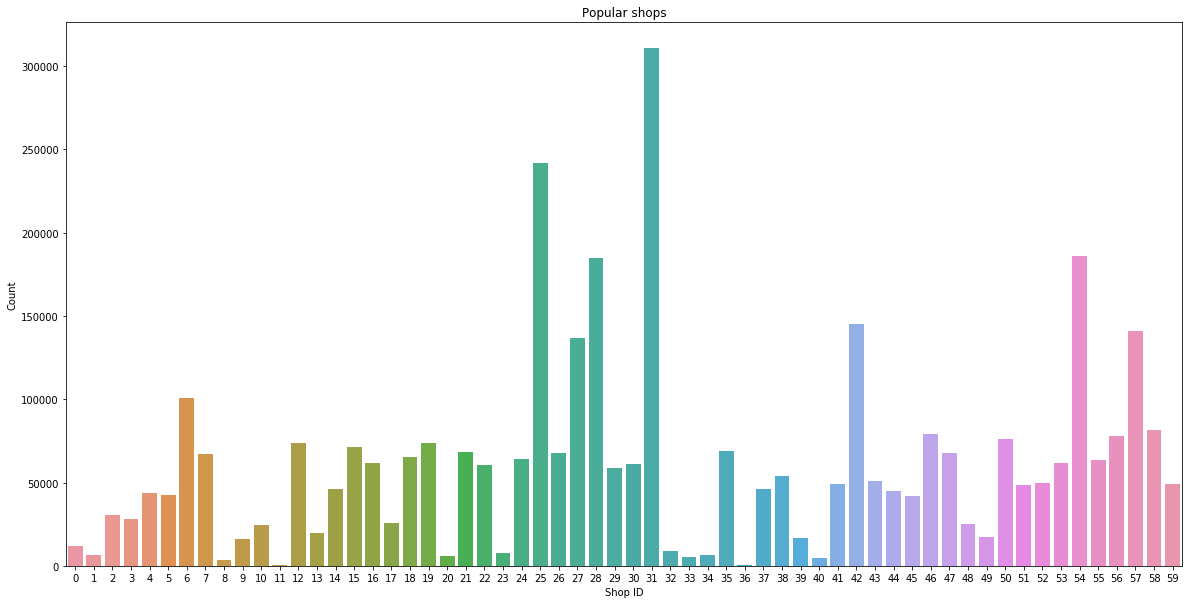

In [10]:
# plot popular shops
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(pop_shops.index, pop_shops.values)
plt.xlabel("Shop ID")
plt.ylabel("Count")
plt.title("Popular shops");
# one can see shop 31 sold the most items in the last 33 months

In [11]:
# look at popular items
pop_items = train.groupby('item_id')['item_cnt_day'].sum()
pop_items = pop_items.sort_values(ascending=False)[:20]

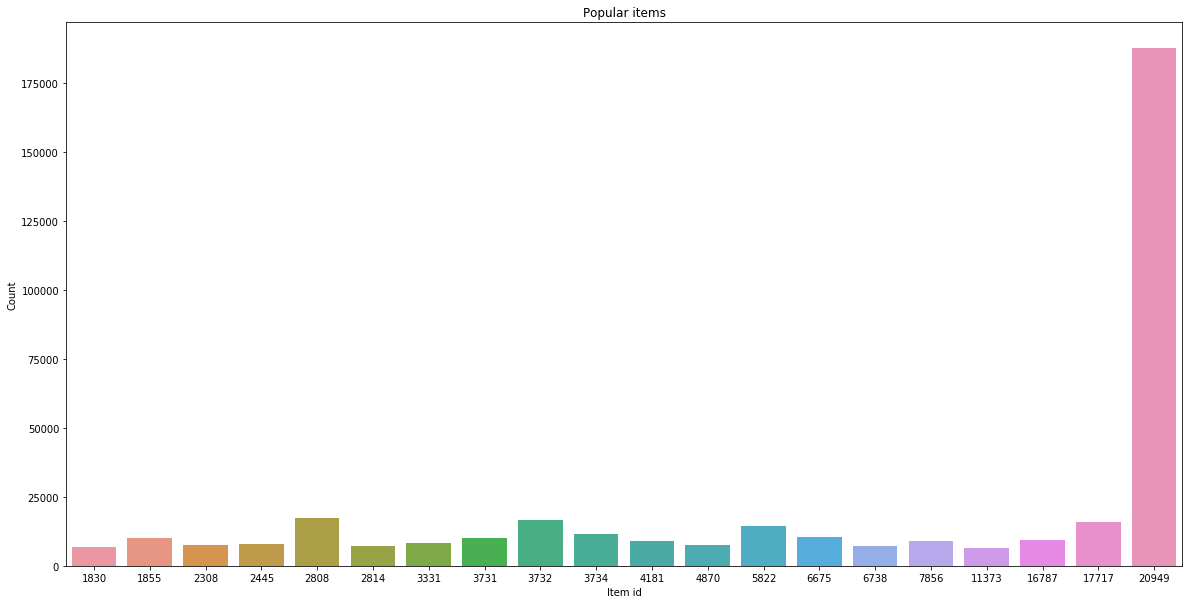

In [12]:
# plot popular items
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(pop_items.index, pop_items.values)
plt.xlabel('Item id')
plt.ylabel('Count')
plt.title('Popular items');
# one can see that item 20494 was sold the most

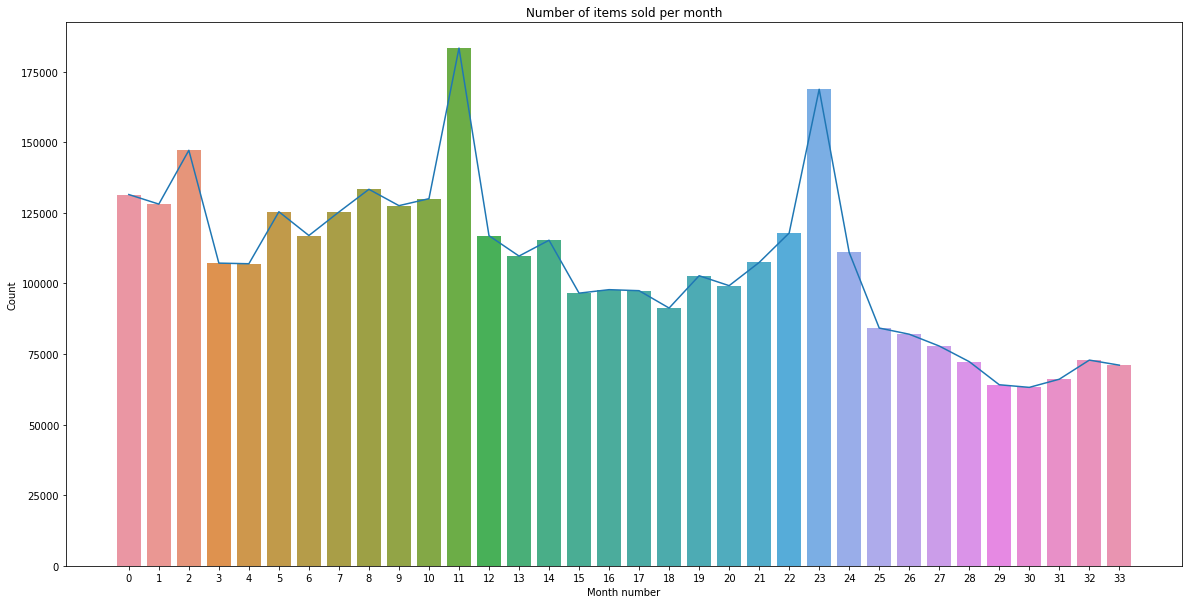

In [13]:
# look at items sold per month and plot
item_cnt_month = train.groupby('date_block_num')['item_cnt_day'].sum()
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(item_cnt_month.index, item_cnt_month.values)
plt.plot(item_cnt_month.index, item_cnt_month.values)
plt.xlabel('Month number')
plt.ylabel('Count')
plt.title('Number of items sold per month');
# one can see a decrease over time in the number of sold items. 
# month #11 had the highest number of sold items

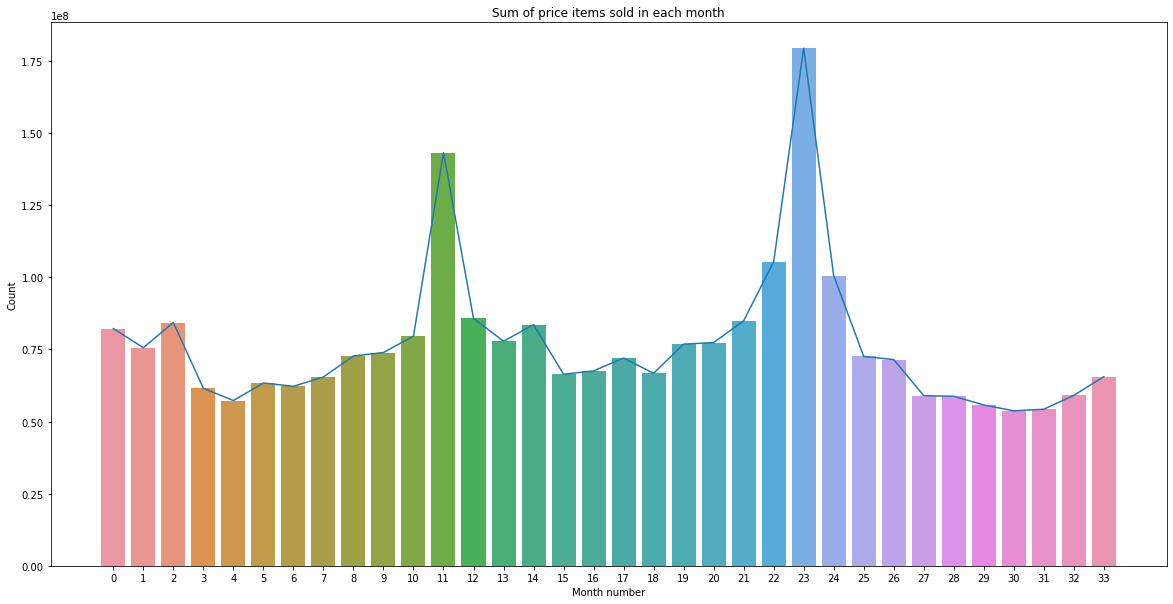

In [14]:
# look at the sum of prices sold per month and plot
price_cnt_month = train.groupby('date_block_num')['item_price'].sum()
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(price_cnt_month.index, price_cnt_month.values)
plt.plot(price_cnt_month.index, price_cnt_month.values)
plt.xlabel('Month number')
plt.ylabel('Count')
plt.title('Sum of price items sold in each month');

# Feature engineering and preprocessing

### Hnadle outliers

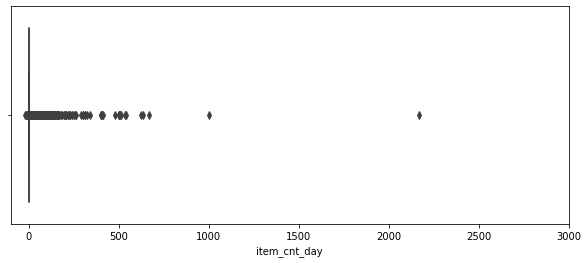

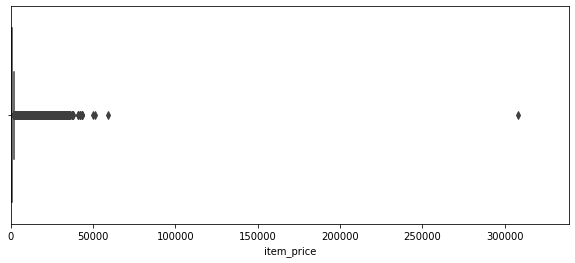

In [15]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price);

Remove items with price > 100000 and sales > 1001

In [16]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

Fill item with negative price with the median

In [17]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

Remove duplicated shops

In [18]:

train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

Extract city name from `shop_name`

Extract type and subtype from category

In [19]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])

item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

Add year and month columns to train

In [20]:
train['year'] = pd.DatetimeIndex(train['date']).year
train['month'] = pd.DatetimeIndex(train['date']).month
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
0,02.01.2013,0,59,22154,999.00,1.0,2013,2
1,03.01.2013,0,25,2552,899.00,1.0,2013,3
2,05.01.2013,0,25,2552,899.00,-1.0,2013,5
3,06.01.2013,0,25,2554,1709.05,1.0,2013,6
4,15.01.2013,0,25,2555,1099.00,1.0,2013,1


Create a matrix with all combinations of 'shop_id', 'item_id', 'date_block_num'

In [21]:

grouping_columns = ['shop_id', 'item_id', 'date_block_num']
date_block_num = train['date_block_num'].unique()
matrix = []
for block in date_block_num:
    temp_shops = train[train['date_block_num'] == block].shop_id.unique()
    temp_items = train[train['date_block_num'] == block].shop_id.unique()
    temp_comb = np.array(list(product(*[temp_shops, temp_items, [block]])))
    matrix.append(temp_comb)
matrix = pd.DataFrame(np.vstack(matrix), columns=grouping_columns)
matrix = pd.concat([matrix, test])
matrix.head()

/Users/ayalaallon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


,date_block_num,item_id,shop_id
0,0.0,59,59
1,0.0,25,59
2,0.0,24,59
3,0.0,23,59
4,0.0,19,59


Add `revenue`feature

In [22]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,revenue
0,02.01.2013,0,59,22154,999.00,1.0,2013,2,999.00
1,03.01.2013,0,25,2552,899.00,1.0,2013,3,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,2013,5,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,2013,6,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,2013,1,1099.00


Create the target variable which I need to predict

In [23]:

group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
display(group.head())

matrix = pd.merge(matrix, group, on=grouping_columns, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0,20) .astype(np.float16))

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


Calculate mean for every `shop_id` x `item_id` x `item_cnt_month`

In [24]:
shop_item_monthly_mean = matrix[['shop_id', 'item_id', 'item_cnt_month']]
shop_item_monthly_mean = shop_item_monthly_mean.groupby(['shop_id', 'item_id'], as_index=False)[['item_cnt_month']].mean() 
shop_item_monthly_mean = shop_item_monthly_mean.rename(columns={'item_cnt_month':'item_cnt_month_mean'})
shop_item_monthly_mean.head()

,shop_id,item_id,item_cnt_month_mean
0,2,2,0.0
1,2,3,0.0
2,2,4,0.0
3,2,5,0.0
4,2,6,0.0


Merge `shop_item_monthly_mean` to matrix

In [25]:
matrix = pd.merge(matrix, shop_item_monthly_mean, on=['shop_id', 'item_id'], how='left')
matrix.head()


,date_block_num,item_id,shop_id,item_cnt_month,item_cnt_month_mean
0,0.0,59,59,0.0,0.0
1,0.0,25,59,0.0,0.0
2,0.0,24,59,0.0,0.0
3,0.0,23,59,0.0,0.0
4,0.0,19,59,0.0,0.0


Add `date_block_num` to test and convert column type to ints

In [26]:

test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.head()

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


Merge test to matrix so I can calculate time features

In [27]:
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=grouping_columns)
matrix.fillna(0, inplace=True) 

Merge `shops`, `items`, and `item_categories` to matrix

In [28]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, item_categories, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
matrix.head()

,date_block_num,item_id,shop_id,item_cnt_month,item_cnt_month_mean,city_code,item_category_id,type_code,subtype_code
0,0.0,59,59,0.0,0.0,30,57,13,8
1,0.0,25,59,0.0,0.0,30,40,11,4
2,0.0,24,59,0.0,0.0,30,40,11,4
3,0.0,23,59,0.0,0.0,30,40,11,4
4,0.0,19,59,0.0,0.0,30,40,11,4


Calculate mean `item_cnt_month` for each `date_block_num` and append to matrix

In [29]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_avg_item_cnt']

matrix = pd.merge(matrix, group, how='left', left_on='date_block_num', right_on='date_block_num')
matrix.head()

,date_block_num,item_id,shop_id,item_cnt_month,item_cnt_month_mean,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt
0,0.0,59,59,0.0,0.0,30,57,13,8,0.001993
1,0.0,25,59,0.0,0.0,30,40,11,4,0.001993
2,0.0,24,59,0.0,0.0,30,40,11,4,0.001993
3,0.0,23,59,0.0,0.0,30,40,11,4,0.001993
4,0.0,19,59,0.0,0.0,30,40,11,4,0.001993


Calculate mean item_cnt_month for each `date_block_num` x `item_id` and append to matrix

In [30]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_avg_item_cnt']

matrix = pd.merge(matrix, group, how='left', left_on=['date_block_num', 'item_id'], right_on=['date_block_num', 'item_id'])
matrix.head()

,date_block_num,item_id,shop_id,item_cnt_month,item_cnt_month_mean,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt,date_item_avg_item_cnt
0,0.0,59,59,0.0,0.0,30,57,13,8,0.001993,0.206909
1,0.0,25,59,0.0,0.0,30,40,11,4,0.001993,0.000000
2,0.0,24,59,0.0,0.0,30,40,11,4,0.001993,0.000000
3,0.0,23,59,0.0,0.0,30,40,11,4,0.001993,0.000000
4,0.0,19,59,0.0,0.0,30,40,11,4,0.001993,0.022217


Calculate mean item_cnt_month for each `date_block_num` x `shop_id` and append to matrix

In [31]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_avg_item_cnt']

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')

Calculate mean item_cnt_month for each `date_block_num` x `item_category_id` and append to matrix

In [32]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix.head()



,date_block_num,item_id,shop_id,item_cnt_month,item_cnt_month_mean,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt,date_item_avg_item_cnt,date_shop_avg_item_cnt,date_cat_avg_item_cnt
0,0.0,59,59,0.0,0.0,30,57,13,8,0.001993,0.206909,0.000777,0.017227
1,0.0,25,59,0.0,0.0,30,40,11,4,0.001993,0.000000,0.000777,0.009666
2,0.0,24,59,0.0,0.0,30,40,11,4,0.001993,0.000000,0.000777,0.009666
3,0.0,23,59,0.0,0.0,30,40,11,4,0.001993,0.000000,0.000777,0.009666
4,0.0,19,59,0.0,0.0,30,40,11,4,0.001993,0.022217,0.000777,0.009666


Calculate mean item_cnt_month for each `date_block_num` x `shop_id` x `item_category_id` and append to matrix

In [33]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')

Calculate mean item_cnt_month for each `date_block_num` x `shop_id` x `subtype_code` and append to matrix

In [34]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')

Calculate mean item_cnt_month for each `date_block_num` x `shop_id` x `type_code` and append to matrix

In [35]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')

Calculate mean item_cnt_month for each `date_block_num` x `city_code` and append to matrix

In [36]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')

Calculate mean item_cnt_month for each `date_block_num` x `item_id` x `city_code` and append to matrix

In [37]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')

Calculate mean item_cnt_month for each `date_block_num` x `type_code` and append to matrix

In [38]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')

Calculate mean item_cnt_month for each `date_block_num` x `subtype_code` and append to matrix

In [39]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')

### Calculate lag features

In [40]:
def get_lag_features(df ,cols, target_col, lags):
    for lag in lags:
        lag_col = df.groupby(cols, as_index=False)[target_col].shift(lag)
        col_name = '_'.join(cols + [target_col] + [str(lag)])
        lag_col.columns = [col_name]
        df = pd.concat([df, lag_col], axis=1)
        df[col_name]= df[col_name].astype(np.float16)
    return df

In [41]:
lags = [1, 2, 3, 4, 5, 6, 7, 12]
matrix = get_lag_features(matrix, ['shop_id', 'item_id'], 'item_cnt_month', lags)
matrix = get_lag_features(matrix, ['shop_id', 'item_id'], 'item_cnt_month_mean', lags)
matrix = get_lag_features(matrix, ['date_block_num'], 'date_avg_item_cnt', lags)
matrix = get_lag_features(matrix, ['date_block_num', 'item_id'], 'date_item_avg_item_cnt', lags)
matrix = get_lag_features(matrix, ['date_block_num', 'shop_id'], 'date_shop_avg_item_cnt', lags)
matrix = get_lag_features(matrix, ['date_block_num','item_category_id'], 'date_cat_avg_item_cnt', lags)
matrix = get_lag_features(matrix, ['date_block_num', 'shop_id', 'item_category_id'], 'date_shop_cat_avg_item_cnt', lags)
matrix = get_lag_features(matrix, ['date_block_num', 'shop_id', 'subtype_code'], 'date_shop_subtype_avg_item_cnt', lags)
matrix = get_lag_features(matrix, ['date_block_num', 'shop_id', 'type_code'], 'date_shop_type_avg_item_cnt', lags)
matrix = get_lag_features(matrix, ['date_block_num', 'city_code'], 'date_city_avg_item_cnt', lags)
matrix = get_lag_features(matrix, ['date_block_num', 'item_id', 'city_code'], 'date_item_city_avg_item_cnt', lags)
matrix = get_lag_features(matrix, ['date_block_num', 'type_code'], 'date_type_avg_item_cnt', lags)
matrix = get_lag_features(matrix, ['date_block_num', 'subtype_code'], 'date_subtype_avg_item_cnt', lags)


display(matrix.head(20))

matrix = matrix.fillna(0)

,date_block_num,item_id,shop_id,item_cnt_month,item_cnt_month_mean,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt,date_item_avg_item_cnt,date_shop_avg_item_cnt,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_shop_subtype_avg_item_cnt,date_shop_type_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt,date_type_avg_item_cnt,date_subtype_avg_item_cnt,shop_id_item_id_item_cnt_month_1,shop_id_item_id_item_cnt_month_2,shop_id_item_id_item_cnt_month_3,shop_id_item_id_item_cnt_month_4,shop_id_item_id_item_cnt_month_5,shop_id_item_id_item_cnt_month_6,shop_id_item_id_item_cnt_month_7,shop_id_item_id_item_cnt_month_12,shop_id_item_id_item_cnt_month_mean_1,shop_id_item_id_item_cnt_month_mean_2,shop_id_item_id_item_cnt_month_mean_3,shop_id_item_id_item_cnt_month_mean_4,shop_id_item_id_item_cnt_month_mean_5,shop_id_item_id_item_cnt_month_mean_6,shop_id_item_id_item_cnt_month_mean_7,shop_id_item_id_item_cnt_month_mean_12,date_block_num_date_avg_item_cnt_1,date_block_num_date_avg_item_cnt_2,date_block_num_date_avg_item_cnt_3,date_block_num_date_avg_item_cnt_4,date_block_num_date_avg_item_cnt_5,date_block_num_date_avg_item_cnt_6,date_block_num_date_avg_item_cnt_7,date_block_num_date_avg_item_cnt_12,date_block_num_item_id_date_item_avg_item_cnt_1,date_block_num_item_id_date_item_avg_item_cnt_2,date_block_num_item_id_date_item_avg_item_cnt_3,date_block_num_item_id_date_item_avg_item_cnt_4,date_block_num_item_id_date_item_avg_item_cnt_5,date_block_num_item_id_date_item_avg_item_cnt_6,date_block_num_item_id_date_item_avg_item_cnt_7,date_block_num_item_id_date_item_avg_item_cnt_12,date_block_num_shop_id_date_shop_avg_item_cnt_1,date_block_num_shop_id_date_shop_avg_item_cnt_2,date_block_num_shop_id_date_shop_avg_item_cnt_3,date_block_num_shop_id_date_shop_avg_item_cnt_4,date_block_num_shop_id_date_shop_avg_item_cnt_5,date_block_num_shop_id_date_shop_avg_item_cnt_6,date_block_num_shop_id_date_shop_avg_item_cnt_7,date_block_num_shop_id_date_shop_avg_item_cnt_12,date_block_num_item_category_id_date_cat_avg_item_cnt_1,date_block_num_item_category_id_date_cat_avg_item_cnt_2,date_block_num_item_category_id_date_cat_avg_item_cnt_3,date_block_num_item_category_id_date_cat_avg_item_cnt_4,date_block_num_item_category_id_date_cat_avg_item_cnt_5,date_block_num_item_category_id_date_cat_avg_item_cnt_6,date_block_num_item_category_id_date_cat_avg_item_cnt_7,date_block_num_item_category_id_date_cat_avg_item_cnt_12,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_1,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_2,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_3,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_4,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_5,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_6,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_7,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_12,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_1,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_2,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_3,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_4,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_5,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_6,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_7,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_12,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_1,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_2,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_3,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_4,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_5,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_6,date_block_num_shop_id_type_code_date_shop_type_avg_item_

In [42]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

matrix = get_lag_features(matrix, ['date_block_num','item_id'], 'date_item_avg_item_price', lags)

# for i in lags:
#     matrix['delta_price_lag_'+str(i)] = \
#         (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

# def select_trend(row):
#     for i in lags:
#         if row['delta_price_lag_'+str(i)]:
#             return row['delta_price_lag_'+str(i)]
#     return 0
    
# matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
# matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
# matrix['delta_price_lag'].fillna(0, inplace=True)


# fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
# for i in lags:
#     fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
#     fetures_to_drop += ['delta_price_lag_'+str(i)]

# matrix.drop(fetures_to_drop, axis=1, inplace=True)

In [43]:
matrix.head()

,date_block_num,item_id,shop_id,item_cnt_month,item_cnt_month_mean,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt,date_item_avg_item_cnt,date_shop_avg_item_cnt,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_shop_subtype_avg_item_cnt,date_shop_type_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt,date_type_avg_item_cnt,date_subtype_avg_item_cnt,shop_id_item_id_item_cnt_month_1,shop_id_item_id_item_cnt_month_2,shop_id_item_id_item_cnt_month_3,shop_id_item_id_item_cnt_month_4,shop_id_item_id_item_cnt_month_5,shop_id_item_id_item_cnt_month_6,shop_id_item_id_item_cnt_month_7,shop_id_item_id_item_cnt_month_12,shop_id_item_id_item_cnt_month_mean_1,shop_id_item_id_item_cnt_month_mean_2,shop_id_item_id_item_cnt_month_mean_3,shop_id_item_id_item_cnt_month_mean_4,shop_id_item_id_item_cnt_month_mean_5,shop_id_item_id_item_cnt_month_mean_6,shop_id_item_id_item_cnt_month_mean_7,shop_id_item_id_item_cnt_month_mean_12,date_block_num_date_avg_item_cnt_1,date_block_num_date_avg_item_cnt_2,date_block_num_date_avg_item_cnt_3,date_block_num_date_avg_item_cnt_4,date_block_num_date_avg_item_cnt_5,date_block_num_date_avg_item_cnt_6,date_block_num_date_avg_item_cnt_7,date_block_num_date_avg_item_cnt_12,date_block_num_item_id_date_item_avg_item_cnt_1,date_block_num_item_id_date_item_avg_item_cnt_2,date_block_num_item_id_date_item_avg_item_cnt_3,date_block_num_item_id_date_item_avg_item_cnt_4,date_block_num_item_id_date_item_avg_item_cnt_5,date_block_num_item_id_date_item_avg_item_cnt_6,date_block_num_item_id_date_item_avg_item_cnt_7,date_block_num_item_id_date_item_avg_item_cnt_12,date_block_num_shop_id_date_shop_avg_item_cnt_1,date_block_num_shop_id_date_shop_avg_item_cnt_2,date_block_num_shop_id_date_shop_avg_item_cnt_3,date_block_num_shop_id_date_shop_avg_item_cnt_4,date_block_num_shop_id_date_shop_avg_item_cnt_5,date_block_num_shop_id_date_shop_avg_item_cnt_6,date_block_num_shop_id_date_shop_avg_item_cnt_7,date_block_num_shop_id_date_shop_avg_item_cnt_12,date_block_num_item_category_id_date_cat_avg_item_cnt_1,date_block_num_item_category_id_date_cat_avg_item_cnt_2,date_block_num_item_category_id_date_cat_avg_item_cnt_3,date_block_num_item_category_id_date_cat_avg_item_cnt_4,date_block_num_item_category_id_date_cat_avg_item_cnt_5,date_block_num_item_category_id_date_cat_avg_item_cnt_6,date_block_num_item_category_id_date_cat_avg_item_cnt_7,date_block_num_item_category_id_date_cat_avg_item_cnt_12,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_1,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_2,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_3,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_4,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_5,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_6,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_7,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_12,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_1,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_2,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_3,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_4,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_5,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_6,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_7,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_12,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_1,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_2,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_3,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_4,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_5,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_6,date_block_num_shop_id_type_code_date_shop_type_avg_item_

In [44]:
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

# matrix = lag_feature(matrix, [1], 'delta_revenue')

# matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
# matrix.head()

In [45]:
matrix['month'] = matrix['date_block_num'] % 12

In [46]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [47]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num   

In [48]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num 

In [49]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

In [50]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [51]:
matrix = matrix[matrix.date_block_num > 11]

In [52]:
matrix.columns

Index(['date_block_num', 'item_id', 'shop_id', 'item_cnt_month',
       'item_cnt_month_mean', 'city_code', 'item_category_id', 'type_code',
       'subtype_code', 'date_avg_item_cnt',
       ...
       'date_block_num_item_id_date_item_avg_item_price_12',
       'date_shop_revenue', 'shop_avg_revenue', 'delta_revenue', 'month',
       'days', 'item_shop_last_sale', 'item_last_sale', 'item_shop_first_sale',
       'item_first_sale'],
      dtype='object', length=143)

In [53]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263461 entries, 24937 to 502597
Columns: 143 entries, date_block_num to item_first_sale
dtypes: float16(128), float32(2), float64(4), int64(2), int8(7)
memory usage: 82.2 MB


In [60]:
matrix = matrix.fillna(0)

In [61]:
matrix.to_pickle(os.path.join(data_path, 'data.pkl'))

In [62]:
matrix.head()

,date_block_num,item_id,shop_id,item_cnt_month,item_cnt_month_mean,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt,date_item_avg_item_cnt,date_shop_avg_item_cnt,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_shop_subtype_avg_item_cnt,date_shop_type_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt,date_type_avg_item_cnt,date_subtype_avg_item_cnt,shop_id_item_id_item_cnt_month_1,shop_id_item_id_item_cnt_month_2,shop_id_item_id_item_cnt_month_3,shop_id_item_id_item_cnt_month_4,shop_id_item_id_item_cnt_month_5,shop_id_item_id_item_cnt_month_6,shop_id_item_id_item_cnt_month_7,shop_id_item_id_item_cnt_month_12,shop_id_item_id_item_cnt_month_mean_1,shop_id_item_id_item_cnt_month_mean_2,shop_id_item_id_item_cnt_month_mean_3,shop_id_item_id_item_cnt_month_mean_4,shop_id_item_id_item_cnt_month_mean_5,shop_id_item_id_item_cnt_month_mean_6,shop_id_item_id_item_cnt_month_mean_7,shop_id_item_id_item_cnt_month_mean_12,date_block_num_date_avg_item_cnt_1,date_block_num_date_avg_item_cnt_2,date_block_num_date_avg_item_cnt_3,date_block_num_date_avg_item_cnt_4,date_block_num_date_avg_item_cnt_5,date_block_num_date_avg_item_cnt_6,date_block_num_date_avg_item_cnt_7,date_block_num_date_avg_item_cnt_12,date_block_num_item_id_date_item_avg_item_cnt_1,date_block_num_item_id_date_item_avg_item_cnt_2,date_block_num_item_id_date_item_avg_item_cnt_3,date_block_num_item_id_date_item_avg_item_cnt_4,date_block_num_item_id_date_item_avg_item_cnt_5,date_block_num_item_id_date_item_avg_item_cnt_6,date_block_num_item_id_date_item_avg_item_cnt_7,date_block_num_item_id_date_item_avg_item_cnt_12,date_block_num_shop_id_date_shop_avg_item_cnt_1,date_block_num_shop_id_date_shop_avg_item_cnt_2,date_block_num_shop_id_date_shop_avg_item_cnt_3,date_block_num_shop_id_date_shop_avg_item_cnt_4,date_block_num_shop_id_date_shop_avg_item_cnt_5,date_block_num_shop_id_date_shop_avg_item_cnt_6,date_block_num_shop_id_date_shop_avg_item_cnt_7,date_block_num_shop_id_date_shop_avg_item_cnt_12,date_block_num_item_category_id_date_cat_avg_item_cnt_1,date_block_num_item_category_id_date_cat_avg_item_cnt_2,date_block_num_item_category_id_date_cat_avg_item_cnt_3,date_block_num_item_category_id_date_cat_avg_item_cnt_4,date_block_num_item_category_id_date_cat_avg_item_cnt_5,date_block_num_item_category_id_date_cat_avg_item_cnt_6,date_block_num_item_category_id_date_cat_avg_item_cnt_7,date_block_num_item_category_id_date_cat_avg_item_cnt_12,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_1,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_2,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_3,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_4,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_5,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_6,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_7,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_12,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_1,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_2,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_3,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_4,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_5,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_6,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_7,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_12,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_1,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_2,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_3,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_4,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_5,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_6,date_block_num_shop_id_type_code_date_shop_type_avg_item_

# Build model

In [67]:
data = pd.read_pickle(os.path.join(data_path, 'data.pkl'))

In [68]:
data = data[['date_block_num',
 'item_id',
 'shop_id',
 'item_cnt_month',
 'item_cnt_month_mean',
 'city_code',
 'item_category_id',
 'type_code',
 'subtype_code',
 'shop_id_item_id_item_cnt_month_1',
 'shop_id_item_id_item_cnt_month_2',
 'shop_id_item_id_item_cnt_month_3',
 'shop_id_item_id_item_cnt_month_4',
 'shop_id_item_id_item_cnt_month_5',
 'shop_id_item_id_item_cnt_month_6',
 'shop_id_item_id_item_cnt_month_7',
 'shop_id_item_id_item_cnt_month_12',
 'shop_id_item_id_item_cnt_month_mean_1',
 'shop_id_item_id_item_cnt_month_mean_2',
 'shop_id_item_id_item_cnt_month_mean_3',
 'shop_id_item_id_item_cnt_month_mean_4',
 'shop_id_item_id_item_cnt_month_mean_5',
 'shop_id_item_id_item_cnt_month_mean_6',
 'shop_id_item_id_item_cnt_month_mean_7',
 'shop_id_item_id_item_cnt_month_mean_12',
 'date_block_num_date_avg_item_cnt_1',
 'date_block_num_date_avg_item_cnt_2',
 'date_block_num_date_avg_item_cnt_3',
 'date_block_num_date_avg_item_cnt_4',
 'date_block_num_date_avg_item_cnt_5',
 'date_block_num_date_avg_item_cnt_6',
 'date_block_num_date_avg_item_cnt_7',
 'date_block_num_date_avg_item_cnt_12',
 'date_block_num_item_id_date_item_avg_item_cnt_1',
 'date_block_num_item_id_date_item_avg_item_cnt_2',
 'date_block_num_item_id_date_item_avg_item_cnt_3',
 'date_block_num_item_id_date_item_avg_item_cnt_4',
 'date_block_num_item_id_date_item_avg_item_cnt_5',
 'date_block_num_item_id_date_item_avg_item_cnt_6',
 'date_block_num_item_id_date_item_avg_item_cnt_7',
 'date_block_num_item_id_date_item_avg_item_cnt_12',
 'date_block_num_shop_id_date_shop_avg_item_cnt_1',
 'date_block_num_shop_id_date_shop_avg_item_cnt_2',
 'date_block_num_shop_id_date_shop_avg_item_cnt_3',
 'date_block_num_shop_id_date_shop_avg_item_cnt_4',
 'date_block_num_shop_id_date_shop_avg_item_cnt_5',
 'date_block_num_shop_id_date_shop_avg_item_cnt_6',
 'date_block_num_shop_id_date_shop_avg_item_cnt_7',
 'date_block_num_shop_id_date_shop_avg_item_cnt_12',
 'date_block_num_item_category_id_date_cat_avg_item_cnt_1',
 'date_block_num_item_category_id_date_cat_avg_item_cnt_2',
 'date_block_num_item_category_id_date_cat_avg_item_cnt_3',
 'date_block_num_item_category_id_date_cat_avg_item_cnt_4',
 'date_block_num_item_category_id_date_cat_avg_item_cnt_5',
 'date_block_num_item_category_id_date_cat_avg_item_cnt_6',
 'date_block_num_item_category_id_date_cat_avg_item_cnt_7',
 'date_block_num_item_category_id_date_cat_avg_item_cnt_12',
 'date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_1',
 'date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_2',
 'date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_3',
 'date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_4',
 'date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_5',
 'date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_6',
 'date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_7',
 'date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_12',
 'date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_1',
 'date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_2',
 'date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_3',
 'date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_4',
 'date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_5',
 'date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_6',
 'date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_7',
 'date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_12',
 'date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_1',
 'date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_2',
 'date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_3',
 'date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_4',
 'date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_5',
 'date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_6',
 'date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_7',
 'date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_12',
 'date_block_num_city_code_date_city_avg_item_cnt_1',
 'date_block_num_city_code_date_city_avg_item_cnt_2',
 'date_block_num_city_code_date_city_avg_item_cnt_3',
 'date_block_num_city_code_date_city_avg_item_cnt_4',
 'date_block_num_city_code_date_city_avg_item_cnt_5',
 'date_block_num_city_code_date_city_avg_item_cnt_6',
 'date_block_num_city_code_date_city_avg_item_cnt_7',
 'date_block_num_city_code_date_city_avg_item_cnt_12',
 'date_block_num_item_id_city_code_date_item_city_avg_item_cnt_1',
 'date_block_num_item_id_city_code_date_item_city_avg_item_cnt_2',
 'date_block_num_item_id_city_code_date_item_city_avg_item_cnt_3',
 'date_block_num_item_id_city_code_date_item_city_avg_item_cnt_4',
 'date_block_num_item_id_city_code_date_item_city_avg_item_cnt_5',
 'date_block_num_item_id_city_code_date_item_city_avg_item_cnt_6',
 'date_block_num_item_id_city_code_date_item_city_avg_item_cnt_7',
 'date_block_num_item_id_city_code_date_item_city_avg_item_cnt_12',
 'date_block_num_type_code_date_type_avg_item_cnt_1',
 'date_block_num_type_code_date_type_avg_item_cnt_2',
 'date_block_num_type_code_date_type_avg_item_cnt_3',
 'date_block_num_type_code_date_type_avg_item_cnt_4',
 'date_block_num_type_code_date_type_avg_item_cnt_5',
 'date_block_num_type_code_date_type_avg_item_cnt_6',
 'date_block_num_type_code_date_type_avg_item_cnt_7',
 'date_block_num_type_code_date_type_avg_item_cnt_12',
 'date_block_num_subtype_code_date_subtype_avg_item_cnt_1',
 'date_block_num_subtype_code_date_subtype_avg_item_cnt_2',
 'date_block_num_subtype_code_date_subtype_avg_item_cnt_3',
 'date_block_num_subtype_code_date_subtype_avg_item_cnt_4',
 'date_block_num_subtype_code_date_subtype_avg_item_cnt_5',
 'date_block_num_subtype_code_date_subtype_avg_item_cnt_6',
 'date_block_num_subtype_code_date_subtype_avg_item_cnt_7',
 'date_block_num_subtype_code_date_subtype_avg_item_cnt_12',
 'item_avg_item_price',
 'date_item_avg_item_price',
 'date_block_num_item_id_date_item_avg_item_price_1',
 'date_block_num_item_id_date_item_avg_item_price_2',
 'date_block_num_item_id_date_item_avg_item_price_3',
 'date_block_num_item_id_date_item_avg_item_price_4',
 'date_block_num_item_id_date_item_avg_item_price_5',
 'date_block_num_item_id_date_item_avg_item_price_6',
 'date_block_num_item_id_date_item_avg_item_price_7',
 'date_block_num_item_id_date_item_avg_item_price_12',
 'date_shop_revenue',
 'shop_avg_revenue',
 'delta_revenue',
 'month',
 'days',
 'item_shop_last_sale',
 'item_last_sale',
 'item_shop_first_sale',
 'item_first_sale']]


In [69]:
data.head()

,date_block_num,item_id,shop_id,item_cnt_month,item_cnt_month_mean,city_code,item_category_id,type_code,subtype_code,shop_id_item_id_item_cnt_month_1,shop_id_item_id_item_cnt_month_2,shop_id_item_id_item_cnt_month_3,shop_id_item_id_item_cnt_month_4,shop_id_item_id_item_cnt_month_5,shop_id_item_id_item_cnt_month_6,shop_id_item_id_item_cnt_month_7,shop_id_item_id_item_cnt_month_12,shop_id_item_id_item_cnt_month_mean_1,shop_id_item_id_item_cnt_month_mean_2,shop_id_item_id_item_cnt_month_mean_3,shop_id_item_id_item_cnt_month_mean_4,shop_id_item_id_item_cnt_month_mean_5,shop_id_item_id_item_cnt_month_mean_6,shop_id_item_id_item_cnt_month_mean_7,shop_id_item_id_item_cnt_month_mean_12,date_block_num_date_avg_item_cnt_1,date_block_num_date_avg_item_cnt_2,date_block_num_date_avg_item_cnt_3,date_block_num_date_avg_item_cnt_4,date_block_num_date_avg_item_cnt_5,date_block_num_date_avg_item_cnt_6,date_block_num_date_avg_item_cnt_7,date_block_num_date_avg_item_cnt_12,date_block_num_item_id_date_item_avg_item_cnt_1,date_block_num_item_id_date_item_avg_item_cnt_2,date_block_num_item_id_date_item_avg_item_cnt_3,date_block_num_item_id_date_item_avg_item_cnt_4,date_block_num_item_id_date_item_avg_item_cnt_5,date_block_num_item_id_date_item_avg_item_cnt_6,date_block_num_item_id_date_item_avg_item_cnt_7,date_block_num_item_id_date_item_avg_item_cnt_12,date_block_num_shop_id_date_shop_avg_item_cnt_1,date_block_num_shop_id_date_shop_avg_item_cnt_2,date_block_num_shop_id_date_shop_avg_item_cnt_3,date_block_num_shop_id_date_shop_avg_item_cnt_4,date_block_num_shop_id_date_shop_avg_item_cnt_5,date_block_num_shop_id_date_shop_avg_item_cnt_6,date_block_num_shop_id_date_shop_avg_item_cnt_7,date_block_num_shop_id_date_shop_avg_item_cnt_12,date_block_num_item_category_id_date_cat_avg_item_cnt_1,date_block_num_item_category_id_date_cat_avg_item_cnt_2,date_block_num_item_category_id_date_cat_avg_item_cnt_3,date_block_num_item_category_id_date_cat_avg_item_cnt_4,date_block_num_item_category_id_date_cat_avg_item_cnt_5,date_block_num_item_category_id_date_cat_avg_item_cnt_6,date_block_num_item_category_id_date_cat_avg_item_cnt_7,date_block_num_item_category_id_date_cat_avg_item_cnt_12,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_1,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_2,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_3,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_4,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_5,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_6,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_7,date_block_num_shop_id_item_category_id_date_shop_cat_avg_item_cnt_12,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_1,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_2,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_3,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_4,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_5,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_6,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_7,date_block_num_shop_id_subtype_code_date_shop_subtype_avg_item_cnt_12,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_1,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_2,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_3,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_4,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_5,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_6,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_7,date_block_num_shop_id_type_code_date_shop_type_avg_item_cnt_12,date_block_num_city_code_date_city_avg_item_cnt_1,date_block_num_city_code_date_city_avg_item_cnt_2,date_block_num_city_code_date_city_avg_item_cnt_3,date_block_num_city_code_date_city_avg_item_cnt_4,da

In [70]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [71]:
model1 = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model1.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)


[0]	validation_0-rmse:0.39176	validation_1-rmse:0.36344
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.30514	validation_1-rmse:0.26560
[2]	validation_0-rmse:0.25222	validation_1-rmse:0.20153
[3]	validation_0-rmse:0.21969	validation_1-rmse:0.16213
[4]	validation_0-rmse:0.20209	validation_1-rmse:0.13797
[5]	validation_0-rmse:0.19037	validation_1-rmse:0.12271
[6]	validation_0-rmse:0.18476	validation_1-rmse:0.11644
[7]	validation_0-rmse:0.18161	validation_1-rmse:0.11315
[8]	validation_0-rmse:0.17955	validation_1-rmse:0.10987
[9]	validation_0-rmse:0.17774	validation_1-rmse:0.10836
[10]	validation_0-rmse:0.17645	validation_1-rmse:0.10839
[11]	validation_0-rmse:0.17447	validation_1-rmse:0.10798
[12]	validation_0-rmse:0.17366	validation_1-rmse:0.10746
[13]	validation_0-rmse:0.17217	validation_1-rmse:0.10787
[14]	validation_0-rmse:0.17168	validation_1-rmse:0.10

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [78]:
preds1 = model1.predict(X_valid).clip(0, 20)
test_preds1 = model1.predict(X_test).clip(0, 20)



# save predictions for an ensemble
pickle.dump(Y_pred1, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test1, open('xgb_test.pickle', 'wb'))

In [84]:
model2 = RandomForestRegressor(max_depth=5, n_estimators=100,  random_state=42, criterion='rmse')
model2.fit(X_train, Y_train)

KeyError: 'rmse'

In [79]:
preds2 = model2.predict(X_valid).clip(0, 20)
test_preds2 = model2.predict(X_test).clip(0, 20)

In [82]:
stacked_predictions = np.column_stack((preds1, preds2))
test_stacked_predcitions = np.column_stack((test_preds1, test_preds2))

meta_model = XGBRegressor(max_depth=7, n_estimators=900, min_child_weight=250, colsample_bytree=0.8, subsample=0.8, 
    eta=0.3, seed=42)
meta_model.fit(stacked_predictions, Y_valid)

final_predictions = meta_model.predict(test_stacked_predcitions)

In [83]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": final_predictions
})
submission.to_csv('xgb_submission_stack.csv', index=False)